In [2]:
# Always try to load packages first
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def load_data(path:str) -> list:
    """ load_data should load the excel sheets into pd.DataFrames
    
    args:
        path type(str) -> Path to the dataframe from workspace
    returns:
        list_of_dataframes -> contains each individual dataframe
    """
    construct_path = os.path.dirname(os.getcwd()) # get base path
    data_path =  construct_path + path # construct data path
    list_data = os.listdir(data_path) # list data in data path
    list_dataframe = []
    # lets loop through the list and open it
    for i in list_data:
        if "xls" in i:
            data_frame = pd.read_excel(data_path + f"/{i}", sheet_name = "Sheet1")
            list_dataframe.append(data_frame)
    return list_dataframe

calcium_dataframes = load_data("/Data/Calcium_Imaging/Plates")
calcium_dataframes[0].head()


ImportError: Missing optional dependency 'xlrd'. Install xlrd >= 1.0.0 for Excel support Use pip or conda to install xlrd.

In [6]:
def set_background_correction(data):
    """ Background will be corrected using the last two 
    columns of each individual dataframe and divide each 
    Wavelength individually by the background
    
    args:
        columns (pd.Series) <- list of columns to substract
    """
    # retrieve the background columns
    w1 = data.iloc[:,1].values
    w2 = data.iloc[:,2].values
    
    # remove them from the data
    data_indeced = data.set_index("Time (sec)").iloc[:,2:]
    
    # get the colum names for the two different wavelength
    columns_w1 = [i for i in data_indeced.columns if "W1" in i]
    columns_w2 = [i for i in data_indeced.columns if "W2" in i]    
    
    # divide each of the dataframes by the columns
    data_w1 = data_indeced[columns_w1].T - w1
    data_w2 = data_indeced[columns_w2].T - w2
    return (data_w1.T, data_w2.T)

data_corrected = set_background_correction(calcium_dataframes[0])
print(type(data_corrected))

<class 'tuple'>


In [7]:
def calculate_ration(ratios):
    """ Calculates the 340/380 ratio for calcium imaging by taking
    w1 and w2 and build the quotient"""
    ratio_dataframe = pd.DataFrame()
    for i,t in zip(ratios[0].columns, ratios[1].columns):
        final_ration = ratios[0][i]/ratios[1][t]
        ratio_dataframe[i.split(" ")[0]] = final_ration
    return ratio_dataframe
ratio_dataframe = calculate_ration(data_corrected)
ratio_dataframe.head()

,R2,R3,R4,R5,R6,R7,R8,R9,R10,R11
Time (sec),,,,,,,,,,
0.664,0.631854,0.662980,0.596680,0.555744,0.600602,0.470574,0.641159,0.578252,0.438833,0.446607
1.664,0.631372,0.663340,0.597487,0.554155,0.598522,0.470373,0.641207,0.577514,0.438385,0.446684
2.664,0.631636,0.665212,0.595913,0.555439,0.600518,0.471176,0.643320,0.578660,0.438857,0.446681
3.664,0.631787,0.664040,0.596282,0.556426,0.600208,0.470427,0.644679,0.579641,0.441501,0.446764
4.664,0.631342,0.664914,0.596252,0.557258,0.599713,0.471313,0.645535,0.579373,0.440407,0.447826


<AxesSubplot: xlabel='Time (sec)'>

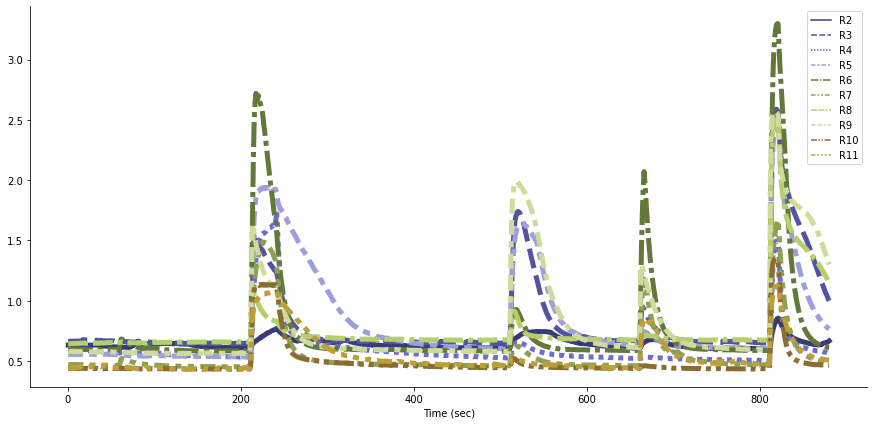

In [8]:
# plot line plot
fig, ax = plt.subplots(figsize = (15,7))
sns.despine()
sns.lineplot(data = ratio_dataframe, palette = "tab20b", linewidth = 5)

In [9]:
def get_mean_graph(ratios):
    """ Calculates the mean and standard error of the mean from the data"""
    mean = ratios.mean(axis = 1)
    sem = ratios.sem(axis = 1)
    return mean, sem

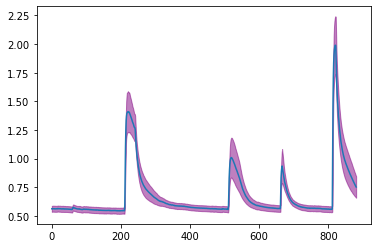

In [10]:
# First way to construct meaned graph
mean, sem = get_mean_graph(ratio_dataframe)
fig,ax = plt.subplots()
ax.plot(mean)
plt.fill_between(mean.index, mean-sem, mean+sem, color = "purple", alpha = 0.5)
plt.show()

<AxesSubplot: xlabel='Time (sec)', ylabel='value'>

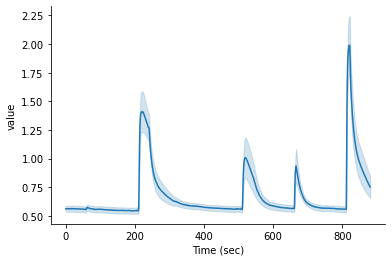

In [11]:
# Second way is we melt the table to long format and redraw
melted = pd.melt(ratio_dataframe.reset_index(), id_vars=['Time (sec)'])
fig, ax = plt.subplots()
sns.despine()
sns.lineplot(x = "Time (sec)", y = "value", data = melted, errorbar = "se")

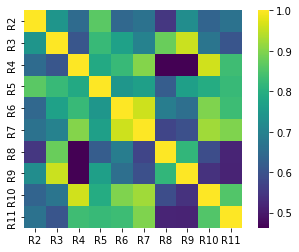

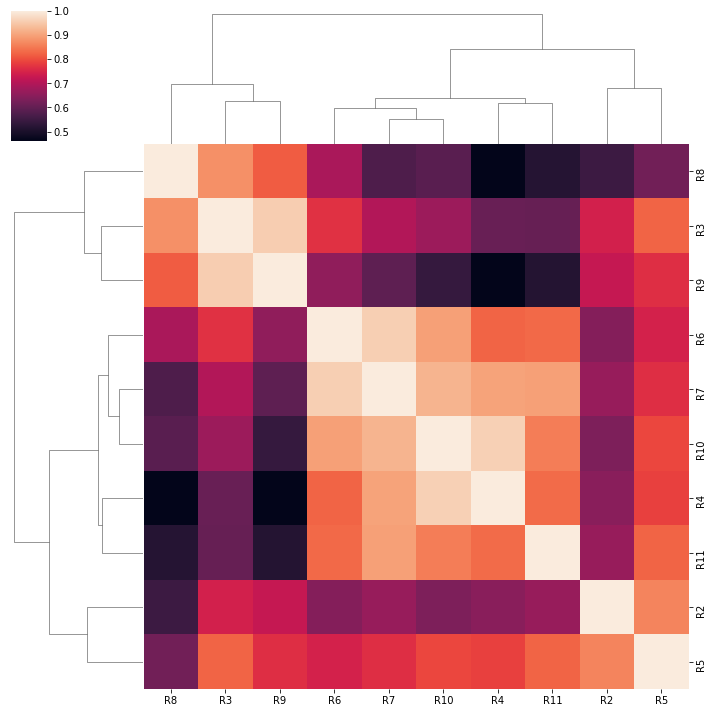

In [13]:
def ratio_corrlation_plot(ratios):
    """ Calculates the correlation matrix from the dataframe
    Args:
        ratios: pd.DataFrame()
    returns:
        matplotlib figure
    """
    correlations = ratios.corr()
    fig, ax = plt.subplots()
    heatmap = sns.heatmap(data = correlations, square = True, cmap = "viridis")
    sns.clustermap(correlations)
ratio_corrlation_plot(ratio_dataframe)